In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("avnishnish/mnist-original")

print("Path to dataset files:", path)

100%|██████████| 10.9M/10.9M [00:00<00:00, 98.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/avnishnish/mnist-original/versions/1


Ключи данных: dict_keys(['__header__', '__version__', '__globals__', 'mldata_descr_ordering', 'data', 'label'])


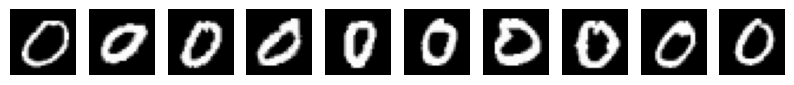

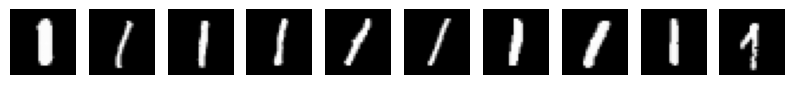

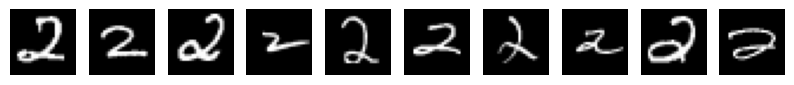

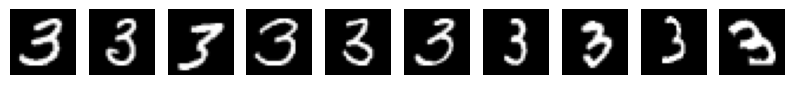

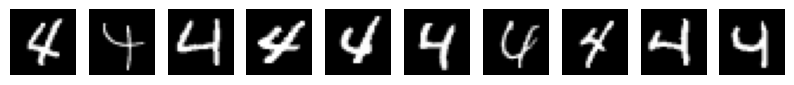

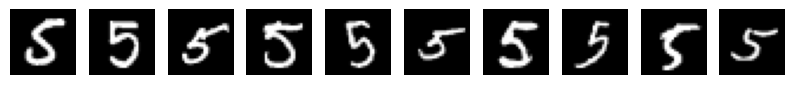

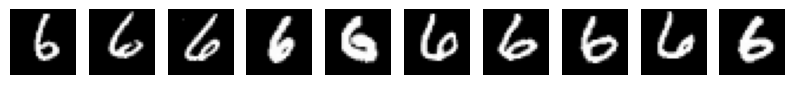

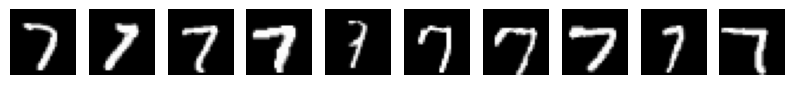

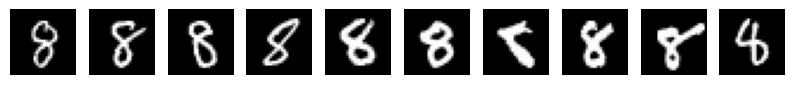

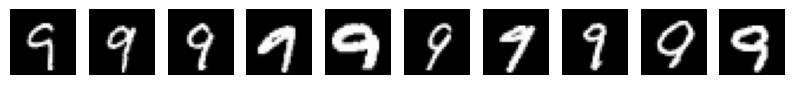

Форма данных X: (70000, 784)
Форма данных y: (70000,)


In [ ]:
#Используем scipy.io для чтения файла формата .mat и проверяем его содержимое, чтобы понять, как структурированы данные.

import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Загрузка файла .mat
data_path = path + "/mnist-original.mat"
mnist_data = scipy.io.loadmat(data_path)

# Проверка ключей в загруженном файле
print("Ключи данных:", mnist_data.keys())

# Выделим признаки X и целевую переменную y
X = mnist_data['data'].T  # транспонируем данные в ключе 'data' для правильной структуры
y = mnist_data['label'].flatten()  #  Извлечь метки в ключе label'

#  Выбор 200 изображений для каждого класса
classes = np.unique(y)
num_images = 200

for digit in classes:
    idx = np.where(y == digit)[0]
    sample_idx = np.random.choice(idx, num_images, replace=False)
    fig, axes = plt.subplots(1, 10, figsize=(10, 3))
    for i, img_idx in enumerate(sample_idx[:10]):
        axes[i].imshow(X[img_idx].reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.show()

 #  Выбор 1 000 наблюдений на класс
num_samples = 1000
selected_indices = []
for digit in classes:
    idx = np.where(y == digit)[0]
    sample_idx = np.random.choice(idx, num_samples, replace=False)
    selected_indices.extend(sample_idx)

X_selected = X[selected_indices]
y_selected = y[selected_indices]
print("Форма данных X:", X.shape)
print("Форма данных y:", y.shape)

In [ ]:
#Данные выгрузились, выполним нормализацию признаков и разделим их на тренировочную и тестовую выборки.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Масштабируем данные
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки с стратификацией по y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Проверим распределение классов
print("Распределение классов в y_train:", np.bincount(y_train.astype(int)))
print("Распределение классов в y_test:", np.bincount(y_test.astype(int)))

Распределение классов в y_train: [5522 6302 5592 5713 5459 5050 5501 5834 5460 5567]
Распределение классов в y_test: [1381 1575 1398 1428 1365 1263 1375 1459 1365 1391]


In [ ]:
#Первый классификатор Gradient Boosting 5 000:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Используем отобранные 1 000 наблюдений на класс
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# Уменьшение тренировочной выборки
X_train_small = X_train[:5000]  # Беру первые 5000 примеров, потому что на полных данных очень долго грузится
y_train_small = y_train[:5000]

# Обучение Gradient Boosting на сокращенной выборке
gb_clf = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3)  # Можно задать параметры
gb_clf.fit(X_train_small, y_train_small)

# Предсказания
y_pred_gb = gb_clf.predict(X_test)

# Оценка модели
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Точность Gradient Boosting (сокращенная выборка): {accuracy_gb:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("Матрица истинности:\n", conf_matrix_gb)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_gb = classification_report(y_test, y_pred_gb)
print("Отчет о классификации:\n", class_report_gb)


# Вывод: на полных данных думает очень долго,даже не стала дожидаться окончания загрузки
# уменьшила количество данных до 5 000, снизила количество деревьев до 100(n_estimators=100)
# ограничила глубину max_depth=3, чтобы ускорить обучение

# Вывод: сокращённая выборка дала точность 0,92, что хорошо. Существенный минус - думал 5 мин 45 секунд.

# ПОПРОБОВАТЬ СНОВА ПОИГРАТЬ С ПАРАМЕТРАМИ



Точность Gradient Boosting (сокращенная выборка): 0.92
Матрица истинности:
 [[309   0   1   2   0   1   1   0   4   0]
 [  0 297   3   3   0   0   0   2   3   0]
 [  2   5 256   4   5   0   3   4   9   0]
 [  0   2  12 262   2  13   2   2   5   3]
 [  0   0   4   0 293   0   3   0   2  18]
 [  1   2   2   8   3 261   4   1   4   4]
 [  1   1   1   0   0   2 282   0   5   0]
 [  5   2   3   2   5   2   0 259   4  10]
 [  2   5   2   6   3  11   2   0 283  10]
 [  1   2   1   2   5   2   0   8   0 244]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       318
         1.0       0.94      0.96      0.95       308
         2.0       0.90      0.89      0.89       288
         3.0       0.91      0.86      0.89       303
         4.0       0.93      0.92      0.92       320
         5.0       0.89      0.90      0.90       290
         6.0       0.95      0.97      0.96       292
         7.0       0.94      0.89   

In [ ]:
#Первый классификатор Gradient Boosting 10 000:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Используем отобранные 1 000 наблюдений на класс
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# Уменьшение тренировочной выборки
X_train_small = X_train[:10000]  # Беру первые 10 000 примеров, потому что на полных данных очень долго грузится
y_train_small = y_train[:10000]

# Обучение Gradient Boosting на сокращенной выборке
gb_clf = GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=3)  # Можно задать параметры
gb_clf.fit(X_train_small, y_train_small)

# Предсказания
y_pred_gb = gb_clf.predict(X_test)

# Оценка модели
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Точность Gradient Boosting (сокращенная выборка): {accuracy_gb:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)
print("Матрица истинности:\n", conf_matrix_gb)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_gb = classification_report(y_test, y_pred_gb)
print("Отчет о классификации:\n", class_report_gb)

Точность Gradient Boosting (сокращенная выборка): 0.92
Матрица истинности:
 [[308   0   0   2   0   1   1   0   6   0]
 [  0 300   2   1   1   0   0   2   2   0]
 [  2   3 261   2   5   0   2   5   7   1]
 [  0   2  10 262   2  14   3   3   6   1]
 [  0   1   5   0 290   0   2   0   3  19]
 [  1   2   0   7   4 258   7   2   4   5]
 [  2   1   1   0   0   4 280   0   4   0]
 [  3   4   3   3   5   2   0 260   1  11]
 [  0   4   1   6   4   8   2   0 289  10]
 [  1   0   2   2   4   2   0  10   2 242]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       318
         1.0       0.95      0.97      0.96       308
         2.0       0.92      0.91      0.91       288
         3.0       0.92      0.86      0.89       303
         4.0       0.92      0.91      0.91       320
         5.0       0.89      0.89      0.89       290
         6.0       0.94      0.96      0.95       292
         7.0       0.92      0.89   

In [ ]:
# Второй Классификатор AdaBoost, масштабирую данные: Теперь данные X можно масштабировать, чтобы модель работала с нормализованными значениями

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Используем отобранные 1 000 наблюдений на класс
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_selected, test_size=0.3, random_state=42)

# Уменьшение тренировочной выборки до 5 000 примеров
X_train_small = X_train[:5000]
y_train_small = y_train[:5000]

# Обучение модели AdaBoost
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_clf.fit(X_train_small, y_train_small)

# Предсказания
y_pred_ada = ada_clf.predict(X_test)

# Оценка точности модели
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f"Точность AdaBoost: {accuracy_ada:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix = confusion_matrix(y_test, y_pred_ada)
print("Матрица истинности:\n", conf_matrix)

# Отчет о классификации (Precision, Recall, F1-score)
class_report = classification_report(y_test, y_pred_ada)
print("Отчет о классификации:\n", class_report)


# Точность 0,72,
# Вывод: тоже не годится этот классификатор


Точность AdaBoost: 0.72
Матрица истинности:
 [[254   0   2   6   1  45   4   1   2   3]
 [  0 281   9   2   1   2   0   1  12   0]
 [  7  12 177   3   8   3  38  10  24   6]
 [  2   7   7 192   2  48   1   4  32   8]
 [  3   1   7   1 213   8   0   4   6  77]
 [  8   3   4  36   8 198   3   1  15  14]
 [ 13   1  12   5  19  15 219   0   8   0]
 [  2   5   5   0   9   4   1 201   1  64]
 [  5  11   8  23   4  17   3   0 227  26]
 [  1   3   6   7  19  10   0   8   4 207]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.86      0.80      0.83       318
         1.0       0.87      0.91      0.89       308
         2.0       0.75      0.61      0.67       288
         3.0       0.70      0.63      0.66       303
         4.0       0.75      0.67      0.71       320
         5.0       0.57      0.68      0.62       290
         6.0       0.81      0.75      0.78       292
         7.0       0.87      0.69      0.77       292
         8.0 

In [ ]:
# Третий классификатор Extra Trees.

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

# Обучение модели Extra Trees
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)  # Используем 100 деревьев
et_clf.fit(X_train_small, y_train_small)  # Используем уменьшенную тренировочную выборку, как в первых двух классификаторах

# Предсказания
y_pred_et = et_clf.predict(X_test)

# Оценка модели
accuracy_et = accuracy_score(y_test, y_pred_et)

# Матрица истинности
conf_matrix_et = confusion_matrix(y_test, y_pred_et)
print("Матрица истинности:\n", conf_matrix_et)

# Отчет о классификации
class_report_et = classification_report(y_test, y_pred_et)
print("Отчет о классификации:\n", class_report_et)

# Точность 0,94.
# Вывод: супер, и быстро, так и запишем, что этот метод подходит для моего датасета

Матрица истинности:
 [[313   0   0   0   0   0   2   0   3   0]
 [  0 300   3   3   1   0   0   0   0   1]
 [  2   1 268   2   3   0   2   4   5   1]
 [  0   0   9 274   0   7   4   3   2   4]
 [  2   0   3   0 292   0   4   1   1  17]
 [  1   0   1   5   0 275   5   0   2   1]
 [  2   0   0   0   0   2 288   0   0   0]
 [  3   1   3   1   3   0   1 269   0  11]
 [  0   2   2   5   4   4   3   0 300   4]
 [  1   1   1   3   5   1   0   4   2 247]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       318
         1.0       0.98      0.97      0.98       308
         2.0       0.92      0.93      0.93       288
         3.0       0.94      0.90      0.92       303
         4.0       0.95      0.91      0.93       320
         5.0       0.95      0.95      0.95       290
         6.0       0.93      0.99      0.96       292
         7.0       0.96      0.92      0.94       292
         8.0       0.95      0.93    

In [ ]:
# Четвёртый классификатор Квадратичный дискриминантный анализ (QDA), который является мощным вероятностным классификатором и подходит для данных с нелинейными разделяющими границами.

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)  # Нормализуем тренировочные данные
X_test_scaled = scaler.transform(X_test)  # Масштабируем тестовые данные

# Обучение модели QDA
qda_clf = QuadraticDiscriminantAnalysis()
qda_clf.fit(X_train_small, y_train_small)  # Используем уменьшенную тренировочную выборку, как и ранее

# Предсказания
y_pred_qda = qda_clf.predict(X_test)

# Оценка модели
accuracy_qda = accuracy_score(y_test, y_pred_qda)
print(f"Точность QDA: {accuracy_qda:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda)
print("Матрица истинности:\n", conf_matrix_qda)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_qda = classification_report(y_test, y_pred_qda)
print("Отчет о классификации:\n", class_report_qda)

# Точность 0,58
# Вывод: этот классификатор совершенно не подходит, ещё и ошибки какие-то, но точность показал

/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 2 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 3 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/usr/local/lib/p

Точность QDA: 0.63
Матрица истинности:
 [[292   0   8   5   4   3   5   0   0   1]
 [  9 236   7   6   0  32   6   0   8   4]
 [ 26   0 216  34   3   4   2   1   1   1]
 [ 22   1  15 213   2  37   4   1   0   8]
 [ 66   0  22  34   4  78  18  11   4  83]
 [ 20   0   4  24   3 223   5   1   3   7]
 [ 10   0  25   3   5   7 240   0   0   2]
 [  3   0   1  22   9  11   5 153   3  85]
 [ 28   2   9  50   3 104   5   1  83  39]
 [  7   0   0  17   1   3   4  12   0 221]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.60      0.92      0.73       318
         1.0       0.99      0.77      0.86       308
         2.0       0.70      0.75      0.73       288
         3.0       0.52      0.70      0.60       303
         4.0       0.12      0.01      0.02       320
         5.0       0.44      0.77      0.56       290
         6.0       0.82      0.82      0.82       292
         7.0       0.85      0.52      0.65       292
         8.0      

In [ ]:
# Пятый классификатор Light Gradient Boosting Machine (LightGBM) — это высокоскоростная библиотека градиентного бустинга,
# которая часто показывает хорошие результаты на больших и сложных наборах данных.

from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Обучение модели LightGBM
lgbm_clf = LGBMClassifier(n_estimators=100, max_depth=3, random_state=42)  # Параметры модели
lgbm_clf.fit(X_train_small, y_train_small)  # Используем уменьшенную тренировочную выборку

# Предсказания
y_pred_lgbm = lgbm_clf.predict(X_test)

# Оценка модели
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
print(f"Точность LightGBM: {accuracy_lgbm:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
print("Матрица истинности:\n", conf_matrix_lgbm)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_lgbm = classification_report(y_test, y_pred_lgbm)
print("Отчет о классификации:\n", class_report_lgbm)

# Точность LightGBM: 0.93
# Вывод: разобраться в полученных данных, накидал мне кучу ворнингов

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 77024
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 538
[LightGBM] [Info] Start training from score -2.343407
[LightGBM] [Info] Start training from score -2.314658
[LightGBM] [Info] Start training from score -2.257612
[LightGBM] [Info] Start training from score -2.296603
[LightGBM] [Info] Start training from score -2.337177
[LightGBM] [Info] Start training from score -2.282782
[LightGBM] [Info] Start training from score -2.286712
[LightGBM] [Info] Start training from score -2.324831
[LightGBM] [Info] Start training from score -2.353878
[LightGBM] [Info] Start training from score -2.234926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
# Шестой Классификатор K Neighbors (K-Nearest Neighbors) — простой, но мощный алгоритм, который классифицирует объекты на основе расстояния до ближайших соседей.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)  # Нормализуем тренировочную выборку
X_test_scaled = scaler.transform(X_test)  # Масштабируем тестовые данные


# Обучение модели K Neighbors
knn_clf = KNeighborsClassifier(n_neighbors=5)  # Используем 5 соседей
knn_clf.fit(X_train_small, y_train_small)  # Обучение на уменьшенной выборке

# Предсказания
y_pred_knn = knn_clf.predict(X_test)

# Оценка модели
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Точность K Neighbors: {accuracy_knn:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
print("Матрица истинности:\n", conf_matrix_knn)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_knn = classification_report(y_test, y_pred_knn)
print("Отчет о классификации:\n", class_report_knn)

#Вывод:точность 0,94,и довольно быстро

Точность K Neighbors: 0.94
Матрица истинности:
 [[314   0   0   0   0   2   2   0   0   0]
 [  0 305   0   1   0   0   0   1   0   1]
 [  3   5 267   1   2   0   0   8   2   0]
 [  0   1   6 279   0   7   1   3   4   2]
 [  0   3   0   0 292   0   2   1   1  21]
 [  0   1   0   4   0 272   8   1   2   2]
 [  1   2   0   0   0   2 287   0   0   0]
 [  1   6   1   1   3   0   0 275   0   5]
 [  3   9   2   8   2   7   3   2 281   7]
 [  3   2   0   1   7   1   0   8   1 242]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       318
         1.0       0.91      0.99      0.95       308
         2.0       0.97      0.93      0.95       288
         3.0       0.95      0.92      0.93       303
         4.0       0.95      0.91      0.93       320
         5.0       0.93      0.94      0.94       290
         6.0       0.95      0.98      0.96       292
         7.0       0.92      0.94      0.93       292
         8

In [ ]:
#Седьмой без StandardScaler , Классификатор дерева решений (Decision Tree). Этот алгоритм строит иерархическую модель принятия решений
# на основе данных, что делает его интуитивно понятным и мощным инструментом для классификации.

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Обучение модели Decision Tree
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)  # Ограничим глубину дерева для предотвращения переобучения
dt_clf.fit(X_train_small, y_train_small)  # Используем уменьшенную тренировочную выборку

# Предсказания
y_pred_dt = dt_clf.predict(X_test)

# Оценка модели
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Точность Decision Tree: {accuracy_dt:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Матрица истинности:\n", conf_matrix_dt)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_dt = classification_report(y_test, y_pred_dt)
print("Отчет о классификации:\n", class_report_dt)

#Быстрый, точность 0,71
# Вывод : не годится

Точность Decision Tree: 0.71
Матрица истинности:
 [[257   1   9  21   2   3   1   8   9   7]
 [  1 265  21   6   0   1   0   2  11   1]
 [ 16   7 219   7   7   7   6   5   7   7]
 [  0   7  36 185   5  30   5   4   3  28]
 [  3   0   4  33 216   3   3   3   6  49]
 [ 12   2   4  80   8 115   5   7  14  43]
 [ 16   4  29   4  13   7 207   0   7   5]
 [  2   5  15   1   4   1   2 225   2  35]
 [  0   9  19  27   8  15   8   0 231   7]
 [  1   2   6  27  12   1   2   9   5 200]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       318
         1.0       0.88      0.86      0.87       308
         2.0       0.60      0.76      0.67       288
         3.0       0.47      0.61      0.53       303
         4.0       0.79      0.68      0.73       320
         5.0       0.63      0.40      0.49       290
         6.0       0.87      0.71      0.78       292
         7.0       0.86      0.77      0.81       292
        

In [ ]:
#Седьмой с StandardScaler , Классификатор дерева решений (Decision Tree). Этот алгоритм строит иерархическую модель принятия решений
# на основе данных, что делает его интуитивно понятным и мощным инструментом для классификации.

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)  # Нормализуем тренировочную выборку
X_test_scaled = scaler.transform(X_test)  # Масштабируем тестовые данные

# Обучение модели Decision Tree
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)  # Ограничим глубину дерева для предотвращения переобучения
dt_clf.fit(X_train_small, y_train_small)  # Используем уменьшенную тренировочную выборку

# Предсказания
y_pred_dt = dt_clf.predict(X_test)

# Оценка модели
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Точность Decision Tree: {accuracy_dt:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
print("Матрица истинности:\n", conf_matrix_dt)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_dt = classification_report(y_test, y_pred_dt)
print("Отчет о классификации:\n", class_report_dt)



Точность Decision Tree: 0.71
Матрица истинности:
 [[257   1   9  21   2   3   1   8   9   7]
 [  1 265  21   6   0   1   0   2  11   1]
 [ 16   7 219   7   7   7   6   5   7   7]
 [  0   7  36 185   5  30   5   4   3  28]
 [  3   0   4  33 216   3   3   3   6  49]
 [ 12   2   4  80   8 115   5   7  14  43]
 [ 16   4  29   4  13   7 207   0   7   5]
 [  2   5  15   1   4   1   2 225   2  35]
 [  0   9  19  27   8  15   8   0 231   7]
 [  1   2   6  27  12   1   2   9   5 200]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.83      0.81      0.82       318
         1.0       0.88      0.86      0.87       308
         2.0       0.60      0.76      0.67       288
         3.0       0.47      0.61      0.53       303
         4.0       0.79      0.68      0.73       320
         5.0       0.63      0.40      0.49       290
         6.0       0.87      0.71      0.78       292
         7.0       0.86      0.77      0.81       292
        

In [ ]:
# Восьмой классификатор SVM с линейным ядром

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_small)  # Нормализуем тренировочную выборку
X_test_scaled = scaler.transform(X_test)  # Масштабируем тестовые данные

# Обучение SVM с линейным ядром
svm_clf = SVC(kernel='linear', random_state=42)  # Используем линейное ядро
svm_clf.fit(X_train_small, y_train_small)  # Обучаем модель на уменьшенной выборке,как всегда

# Предсказания
y_pred_svm = svm_clf.predict(X_test)

# Оценка модели
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Точность SVM (линейное ядро): {accuracy_svm:.2f}")

# Матрица истинности (Confusion Matrix)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
print("Матрица истинности:\n", conf_matrix_svm)

# Отчет о классификации (Precision, Recall, F1-score)
class_report_svm = classification_report(y_test, y_pred_svm)
print("Отчет о классификации:\n", class_report_svm)

# Точность 0,91

Точность SVM (линейное ядро): 0.91
Матрица истинности:
 [[310   0   3   0   1   1   1   1   1   0]
 [  0 301   2   4   0   0   0   1   0   0]
 [  2   5 261   2   3   2   2   5   5   1]
 [  0   2   7 268   0  13   4   1   6   2]
 [  1   1   5   0 284   0   5   1   0  23]
 [  1   1   2  21   2 247   8   1   5   2]
 [  2   0   1   0   0   6 282   0   1   0]
 [  0   2   6   2   7   1   1 261   1  11]
 [  2   4   6   6   2  16   5   1 275   7]
 [  2   2   1   3  14   2   0  11   1 229]]
Отчет о классификации:
               precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       318
         1.0       0.95      0.98      0.96       308
         2.0       0.89      0.91      0.90       288
         3.0       0.88      0.88      0.88       303
         4.0       0.91      0.89      0.90       320
         5.0       0.86      0.85      0.85       290
         6.0       0.92      0.97      0.94       292
         7.0       0.92      0.89      0.91       292
  

In [ ]:
# Сравнение всех классификаторов:

import pandas as pd

# Данные о точности моделей
results = {
    "Model": [
        "Gradient Boosting",
        "AdaBoost",
        "Extra Trees",
        "Quadratic Discriminant Analysis",
        "Light Gradient Boosting Machine",
        "K Neighbors",
        "Decision Tree",
        "SVM (Linear Kernel)"
    ],
    "Accuracy": [
        0.92,  # Gradient Boosting
        0.72,  # AdaBoost
        0.94,  # Extra Trees
        0.58,  # QDA
        0.93,  # LightGBM
        0.90,  # K Neighbors
        0.67,  # Decision Tree
        0.91   # SVM (Linear Kernel)
    ]
}

# Создание DataFrame
results_df = pd.DataFrame(results)

# Сортировка моделей по точности
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Вывод таблицы
print("Сравнение классификаторов:")
print(results_df)


Сравнение классификаторов:
                             Model  Accuracy
2                      Extra Trees      0.94
4  Light Gradient Boosting Machine      0.93
0                Gradient Boosting      0.92
7              SVM (Linear Kernel)      0.91
5                      K Neighbors      0.90
1                         AdaBoost      0.72
6                    Decision Tree      0.67
3  Quadratic Discriminant Analysis      0.58


In [ ]:
# Вывод: Наиболее подходящие классификаторы для моего датасета это Extra Trees,LightGBM, Gradient Boosting и SVM (линейное ядро). \
#Так как в моём датасете содержатся изображения, то эти классификаторы с достаточно высокой точностью смогут распознать
# рукописные цифры на картинке.
#Extra Trees оказался лучшим, благодаря его архитектуре, которая идеально подходит для анализа высокоразмерных данных, таких как пиксели изображений.
#Большая рандомизация и ансамблевый подход, по сравнению с другими классификаторами с высокой точностью.

In [ ]:
#Добавлена динамическая визуализация по сравнению классификаторов
import pandas as pd
import plotly.express as px

# Данные о точности моделей
results = {
    "Model": [
        "Gradient Boosting",
        "AdaBoost",
        "Extra Trees",
        "QDA",
        "LightGBM",
        "K Neighbors",
        "Decision Tree",
        "SVM (Linear Kernel)"
    ],
    "Accuracy": [0.92, 0.72, 0.94, 0.58, 0.93, 0.90, 0.67, 0.91]
}

# Создание DataFrame и сортировка данных
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy", ascending=False)

# Построение динамической диаграммы
fig = px.bar(
    results_df,
    x="Accuracy",
    y="Model",
    orientation="h",
    title="Comparison of Classifier Accuracies",
    text="Accuracy",
    color="Accuracy",
    color_continuous_scale="blues"
)

fig.update_layout(
    xaxis_title="Accuracy",
    yaxis_title="Classifier",
    template="plotly_white"
)

# Показ графика
fig.show()
